# Ensemble Classifier
In this Notebook we want to learn different techniques for creating ensemble classifiers:
- blending
- stacking
- voting

We check the methods on a simple generated dataset from sklearn dataset method *makemoons*.

### Generating Data

In [1]:
# import datasets module
from sklearn import datasets

In [70]:
# use makemoons with a small noise level
#data = datasets.make_moons(n_samples=1000, noise=0.2)
data = datasets.make_classification(n_samples=1000, n_features=2, n_redundant=0)
#data = datasets.make_circles(n_samples=1000, noise=0.2)

In [71]:
# import pandas to create DataFrames
import pandas as pd

In [72]:
# create a df out of the generated data
data_df = pd.DataFrame({'x1': data[0][:,0], 'x2': data[0][:,1], 'y': data[1]})

In [73]:
data_df.head()

,x1,x2,y
0,-2.326196,0.986507,1
1,-1.128043,0.100358,1
2,-1.356487,1.383137,1
3,-0.614446,-1.923766,0
4,0.474798,0.187427,1


### Visualizing the Data

In [74]:
# import seaborn for easy plotting
import seaborn as sns

In [75]:
# to see plots directly in jupyter without issuing *plt.show()*
%matplotlib inline

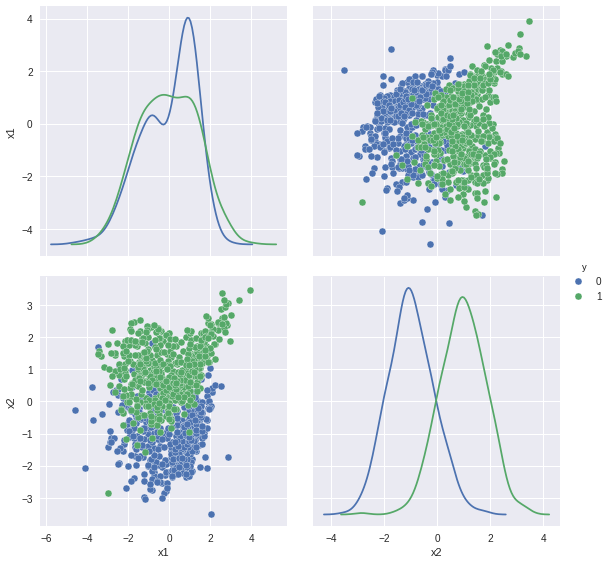

In [76]:
# scatterplots with colored labels
sns.pairplot(data=data_df, hue='y', vars=['x1', 'x2'], diag_kind='kde', size=4)

### Splitting Data into Training and Test Data Sets

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
train, test = train_test_split(data_df, test_size=0.3)

### Splitting the Training Data in KFolds
Next, we perform KFold splitting. This method splits the data into K training and test parts. The training set is the sum of K-1 sets, where the test set is always the *leftover* set. For instance, if we use 3 folds and we have 12 rows of data going from id = 0 to id = 1, we would get the following:

#### Division into three sets:
set1 = $[(x_0, y_0) \cdots (x_3, y_3)]$

set2 = $[(x_4, y_4) \cdots (x_7, y_7)]$ 

set3 = $[(x_8, y_8) \cdots (x_11, y_11)]$ 
#### Combing the sets into three training/test sets:
trainA, testA = (set1 + set2), (set3)

trainB, testB = (set2 + set3), (set1)

trainC, testC = (set1 + set3), (set2)

###### Excursion:
K Fold Cross Validation trains the model on fold 1 to K and computes the testerror with the leftover set. Finally it returns the average of the K test scores. This method is used for hyper parameter tuning.

In [79]:
# module to split data in K Folds
from sklearn.model_selection import KFold

In [80]:
# create instance which generates three folds
twoFold = KFold(n_splits=2, shuffle=True)

In [81]:
# collect fold indices in a list
foldIdx = []
for element in twoFold.split(data_df):
    foldIdx.append(element)

In [82]:
# create three different train and test set combinations (see above)
trainA, testA = data_df.iloc[foldIdx[0][0]], data_df.iloc[foldIdx[0][1]]
trainB, testB = data_df.iloc[foldIdx[1][0]], data_df.iloc[foldIdx[1][1]]
#trainC, testC = data_df.iloc[foldIdx[2][0]], data_df.iloc[foldIdx[2][1]]

If you want you can have a look at the head of the data sets. Notice the indices in the train and test data.

In [83]:
trainA.head()

,x1,x2,y
0,-2.326196,0.986507,1
1,-1.128043,0.100358,1
7,0.684808,0.530849,1
9,-1.326987,-0.420088,1
12,-0.600941,1.435896,1


In [84]:
testA.head()

,x1,x2,y
2,-1.356487,1.383137,1
3,-0.614446,-1.923766,0
4,0.474798,0.187427,1
5,0.488747,-1.561314,0
6,-1.238401,0.630345,1


In [85]:
trainB.head()

,x1,x2,y
2,-1.356487,1.383137,1
3,-0.614446,-1.923766,0
4,0.474798,0.187427,1
5,0.488747,-1.561314,0
6,-1.238401,0.630345,1


In [86]:
testB.head()

,x1,x2,y
0,-2.326196,0.986507,1
1,-1.128043,0.100358,1
7,0.684808,0.530849,1
9,-1.326987,-0.420088,1
12,-0.600941,1.435896,1


### Create Base Classifier
Next we train the base classifiers (layer 0) with the trainA

Let’s say you want to do 2-fold stacking:

Split the train set in 2 parts: train_a and train_b
- Fit a first-stage model on train_a and create predictions for train_b
- Fit the same model on train_b and create predictions for train_a
- Finally fit the model on the entire train set and create predictions for the test set.
- Now train a second-stage stacker model on the probabilities from the first-stage model(s).

Let's get this more straight (http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)

3.2 For each base model 
M1: K-Nearest Neighbors (k = 1) 
M2: Support Vector Machine (type = 4, cost = 1000)

3.2.1 Fit the base model to the training fold and make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model

4 . Fit each base model to the full training dataset and make predictions on the test dataset. Store these predictions inside test_meta

5 . Fit a new model, S (i.e the stacking model) to train_meta, using M1 and M2 as features. Optionally, include other features from the original training dataset or engineered features

6 . Use the stacked model S to make final predictions on test_meta

Useful Links: https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
https://mlwave.com/kaggle-ensembling-guide/
https://mlwave.com/
https://mlwave.com/kaggle-ensembling-guide/

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [88]:
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = KNeighborsClassifier()
clf3 = SVC(probability=True)

In [89]:
trainA.iloc[:,:-1].head()

,x1,x2
0,-2.326196,0.986507
1,-1.128043,0.100358
7,0.684808,0.530849
9,-1.326987,-0.420088
12,-0.600941,1.435896


#### Step1: fit basemodels on folds and make predictions with leftout fold to generate a train_meta dataset

In [90]:
# fit base models with trainA and make predictions with testA
clf1.fit(trainA[['x1','x2']], trainA['y'])
clf1_testA_proba = clf1.predict_proba(testA[['x1','x2']])[:,1]

clf2.fit(trainA[['x1','x2']], trainA['y'])
clf2_testA_proba = clf2.predict_proba(testA[['x1','x2']])[:,1]

clf3.fit(trainA[['x1','x2']], trainA['y'])
clf3_testA_proba = clf3.predict_proba(testA[['x1','x2']])[:,1]

In [91]:
clf1.classes_

array([0, 1])

In [92]:
# fit base models with trainB and make predictions with testB
clf1.fit(trainB[['x1','x2']], trainB['y'])
clf1_testB_proba = clf1.predict_proba(testB[['x1','x2']])[:,1]

clf2.fit(trainB[['x1','x2']], trainB['y'])
clf2_testB_proba = clf2.predict_proba(testB[['x1','x2']])[:,1]

clf3.fit(trainB[['x1','x2']], trainB['y'])
clf3_testB_proba = clf3.predict_proba(testB[['x1','x2']])[:,1]

In [93]:
clf1.classes_

array([0, 1])

Combine the result to a new dataframe for the second layer (layer 1)

In [94]:
# empty df
train_meta = pd.DataFrame()

In [95]:
# add testA and testB to the df as a column
train_meta['y'] = testA['y'].tolist() + testB['y'].tolist()

In [96]:
# add predictions of clf1
train_meta['clf1'] = clf1_testA_proba.tolist() + clf1_testB_proba.tolist()

In [97]:
# add predictions of clf2
train_meta['clf2'] = clf2_testA_proba.tolist() + clf2_testB_proba.tolist()

In [98]:
# add predictions of clf3
train_meta['clf3'] = clf3_testA_proba.tolist() + clf3_testB_proba.tolist()

In [99]:
# check results
train_meta.head(15)

,y,clf1,clf2,clf3
0,1,0.91,1.0,0.899191
1,0,0.00,0.0,0.035193
2,1,0.83,0.8,0.889228
3,0,0.01,0.0,0.020813
4,1,0.90,0.8,0.874352
5,0,0.10,0.2,0.084162
6,0,0.06,0.0,0.081501
7,1,0.97,1.0,0.906821
8,1,0.99,0.8,0.955526
9,0,0.33,0.2,0.126441


#### Step2: fit basemodels on all folds and make predictions with the testdata set

In [100]:
# fit base models with trainB and make predictions with testB
clf1.fit(train[['x1','x2']], train['y'])
clf1_test_proba = clf1.predict_proba(test[['x1','x2']])[:,1]

clf2.fit(train[['x1','x2']], train['y'])
clf2_test_proba = clf2.predict_proba(test[['x1','x2']])[:,1]

clf3.fit(train[['x1','x2']], train['y'])
clf3_test_proba = clf3.predict_proba(test[['x1','x2']])[:,1]

In [101]:
test_meta = pd.DataFrame()
test_meta['y'] = test['y'].tolist()
test_meta['clf1'] = clf1_test_proba.tolist()
test_meta['clf2'] = clf2_test_proba.tolist()
test_meta['clf3'] = clf3_test_proba.tolist()

In [102]:
test_meta.head()

,y,clf1,clf2,clf3
0,0,0.00,0.0,0.027938
1,0,0.48,0.4,0.612167
2,0,0.16,0.0,0.045785
3,1,1.00,1.0,0.977262
4,0,0.18,0.0,0.062694


### Step3: Fit MetaModel

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
metaModel = LogisticRegression()

In [105]:
metaModel.fit(train_meta[['clf1', 'clf2', 'clf3']], train_meta['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### evaluate all Models

In [106]:
metaModel.score(test_meta[['clf1', 'clf2', 'clf3']], test_meta['y'])

0.90333333333333332

In [107]:
clf1.score(test[['x1','x2']], test['y'])

0.8833333333333333

In [108]:
clf2.score(test[['x1','x2']], test['y'])

0.91000000000000003

In [109]:
clf3.score(test[['x1','x2']], test['y'])

0.90666666666666662

### plot decision regions

In [110]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier, StackingCVClassifier

In [111]:
clf_stack = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=metaModel, use_probas=True)
clf_stackCV = StackingCVClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=metaModel,
                                   use_probas=True, cv=5, use_features_in_secondary=True)

In [112]:
clf_stackCV.fit(train[['x1', 'x2']].values, train['y'].values)

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estima...f',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)],
           cv=5,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_features_in_secondary=True, use_probas=True, verbose=0)

In [113]:
clf_stackCV.score(test[['x1','x2']], test['y'])

0.91000000000000003

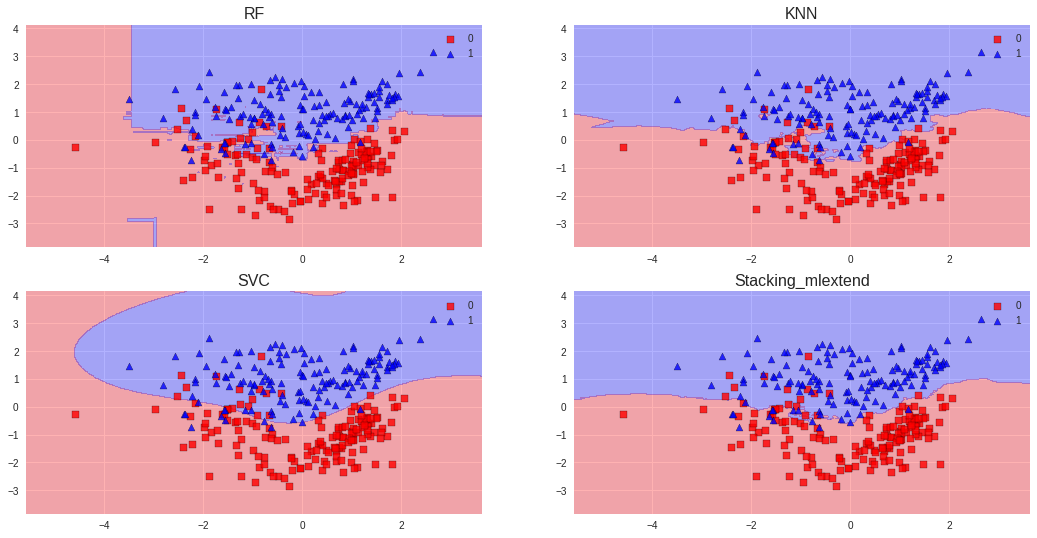

In [114]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(2,2,figsize=(18,9))
axes[0,0].set_title("RF", fontsize=16)
axes[0,1].set_title("KNN", fontsize=16)
axes[1,0].set_title("SVC", fontsize=16)
axes[1,1].set_title("Stacking_mlextend", fontsize=16)
plot_decision_regions(test[['x1','x2']].as_matrix(), test['y'].as_matrix(), clf=clf1, ax=axes[0,0])
plot_decision_regions(test[['x1','x2']].as_matrix(), test['y'].as_matrix(), clf=clf2, ax=axes[0,1])
plot_decision_regions(test[['x1','x2']].as_matrix(), test['y'].as_matrix(), clf=clf3, ax=axes[1,0])
plot_decision_regions(test[['x1','x2']].values, test['y'].values, clf=clf_stackCV, ax=axes[1,1])